<h1>Creating OSM Completeness Model</h1>

<p>This Jupyter notebook takes as input training polygons produced from the <a href="https://observablehq.com/d/176fbd0640a04220">Mapbox OSM Training Set Creation</a> Observable notebook. To use this notebook, you'll also need to sign up for a <a href="https://earthengine.google.com/new_signup/"> Google Earth Engine Account</a>.</p>

In [41]:
import seaborn as sns
import geojson
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, box, mapping, Point, Polygon
import numpy as np
import osmnx as ox
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import math
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats, utils
import gdal, gdalconst

In [3]:
import ee
ee.Authenticate()
ee.Initialize()

In [42]:
#class for GeoJSON feature collections. To complete analysis need two:
#1. training data from Observable notebook
#2. grid data that wil be run through trained model and output
class Features:
    
    def __init__(self, filename=''):
        self.filename = filename
        self.polygons = []
        
        if filename=='':
            return
        
        with open(filename) as f:
            self.data = json.load(f)
        try:
            self.features = self.data['features']
        except:
            print("JSON file did not have features array")
            
    def getPolygons(self):
        for feature in self.features:
            g = shape(feature['geometry']).buffer(0)
            self.polygons.append(g)
        print(len(self.polygons))
        return self.polygons
    
    #used if creating own grid, not reading JSON file in __init__
    def setData(self, df):
        self.data = mapping(df.geometry)
        #don't need bbox for anything so delete it to reduce output file size
        del self.data['bbox']
        for feature in self.data['features']:
            del feature['bbox']
        self.features = self.data['features']
    
    def projectGeoDataFrame(self, *args):
        if len(args) > 0:
            df = args[0]
        else:
            df = self.geoDataFrame
        
        avg_longitude = (self.bounds[0] + self.bounds[2])/2
        utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
        utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
   
        # project the GeoDataFrame to the UTM CRS
        self.geoDataFrameProjected = df.to_crs(utm_crs)
        
        return self.geoDataFrameProjected
    
    def createGeoDataFrame(self):
        self.geoDataFrame = gpd.GeoDataFrame({
            'geometry': self.polygons
        })
        self.geoDataFrame.crs = "EPSG:4326"
        return self.geoDataFrame
        
    def getBounds(self):
        self.bounds = self.geoDataFrame.total_bounds
        return self.bounds
    
    def getClippingBox(self):
        if not hasattr(self, 'bounds'):
            self.getBounds()
        bbox = box(self.bounds[0], self.bounds[1], self.bounds[2], self.bounds[3])
        self.bbox = bbox
        self.clippingBox = {'type': 'Feature', 'properties': {}, 'geometry': mapping(bbox)}
        return self.clippingBox

In [45]:
#class to work with tiff datasets
class Raster:
    
    def __init__(self, filename):
        self.filename = filename
        
    def dataFromBounds(self, band, bounds):
        with rasterio.open(self.filename) as src:
            self.noData = src.nodatavals[0]
            window = rasterio.windows.from_bounds(bounds[0],bounds[1],bounds[2],bounds[3], src.transform)
            self.boundsData = src.read(band, window=window)
            self.boundsTransform = src.window_transform(window)

In [46]:
def eeForest(features):
    ee.Initialize()
    gfcImage = ee.Image("UMD/hansen/global_forest_change_2018_v1_6")
    FCL0018 = gfcImage.select(['loss']).eq(1).rename('fcloss0018')
    FC00 = gfcImage.select(['treecover2000']).gte(20)
    FC18 = FC00.subtract(FCL0018).rename('FC18')
    FC18Area = FC18.multiply(ee.Image.pixelArea()).rename('FC18Area')
    forestSum = FC18Area.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

    return forestSum.getInfo()

In [47]:
def maskEdge(img):
    mask = img.select(0).unitScale(-25, 5).multiply(255).toByte().connectedComponents(ee.Kernel.rectangle(1,1), 100);
    return img.updateMask(mask.select(0))

def eeTexture(features, JSONob):
    ee.Initialize()
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(JSONob.clippingBox['geometry']).filterMetadata('instrumentMode', 'equals', 'IW')
    .select(['VV', 'angle']))

    se1 = s1.select(0).filterDate('2019-01-01', '2019-07-31').median()

    textureMean = se1.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 10
        #maxPixels= 1e9
    )
    return textureMean.getInfo()

In [48]:
def eeSlope(features):
    ee.Initialize()
    srtm = ee.Image("CSP/ERGo/1_0/Global/SRTM_mTPI")
    slope = ee.Terrain.slope(srtm).rename('slope')
    slopeMean = slope.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 270
        #maxPixels= 1e9
    )
    return slopeMean.getInfo()

In [49]:
#only return 2019 
def eeVIIRSNTL(features):
    ee.Initialize()
    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")

    #2019 viirs
    viirs_2019_mean = viirs.select('avg_rad').filterDate('2019-01-01','2019-07-01').mean().rename('viirs_2019_mean')
    viirs_2019_median = viirs.select('avg_rad').filterDate('2019-01-01','2019-07-01').median().rename('viirs_2019_median')
    viirs_2019_max = viirs.select('avg_rad').filterDate('2019-01-01','2019-07-01').max().rename('viirs_2019_max')

    VIIRS2019 = viirs_2019_mean.addBands(viirs_2019_median).addBands(viirs_2019_max)

    stats2019 = VIIRS2019.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

    return stats2019.getInfo()

In [50]:
def maskS2clouds(image):
    qa = image.select('QA60')

    #Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    #Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
            qa.bitwiseAnd(cirrusBitMask).eq(0)))

    #Return the masked and scaled data, without the QA bands.
    return (image.updateMask(mask) #.divide(10000)
      .select("B.*")
      .copyProperties(image, ["system:time_start"]))

def eeIndices(features, JSONob):
   
    ee.Initialize()
    #Map the function over one year of data and take the median.
    #Load Sentinel-2 TOA reflectance data.
    collection = (ee.ImageCollection('COPERNICUS/S2')
        .filterDate('2019-01-01', '2019-07-31')
        #Pre-filter to get less cloudy granules.
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(maskS2clouds))

    composite = collection.median().clip(ee.Feature(JSONob.clippingBox))#.int()  
    ndbi = composite.normalizedDifference(['B11','B8']).rename('ndbi')
    ndvi = composite.normalizedDifference(['B8','B4']).rename('ndvi')
    savi = composite.expression(
        '1.5 * (NIR-RED) / (NIR+RED+0.5)', {
          'NIR': composite.select('B8'),
          'RED': composite.select('B4')
    }).rename('savi').float()
    urbanIndex = composite.normalizedDifference(['B12','B8']).rename('ui')
    sen2AllIndices = ndvi.addBands(ndbi).addBands(savi).addBands(urbanIndex)
    #Calculate Indices
    finalIndices = sen2AllIndices.reduceRegions(
    collection= ee.FeatureCollection(features),
    reducer= ee.Reducer.sum(),
    scale= 10,
    )
    return finalIndices.getInfo()

<p>Download <a href ="https://data.humdata.org/search?organization=facebook&q=high%20resolution%20population&ext_page_size=25&sort=score%20desc%2C%20if(gt(last_modified%2Creview_date)%2Clast_modified%2Creview_date)%20desc">Facebook population data</a> and/or <a href="https://www.worldpop.org/geodata/listing?id=29">WorldPop</a> data for your area of interest and insert the paths into the cell below.</p>

In [51]:
###############################################
# processing training data JSON
###############################################

#change this file path to the location of the json data downloaded from the OSM Training Set Observable notebook
trainingJSON = Features('path_to_file_downloaded_from_Observable')

#order these 6 lines are called is important
trainingPolys = trainingJSON.getPolygons()
trainingDF = trainingJSON.createGeoDataFrame()
trainingFeatures = trainingJSON.features
trainingBounds = trainingJSON.getBounds()
trainingClip = trainingJSON.getClippingBox()
trainingDFProjected = trainingJSON.projectGeoDataFrame(trainingDF)

#Facebook and WorldPop data paths
fbPath = 'path_to_facebook'
wpPath = 'path_to_worldpop'
#World settlement footprint path
wsfPath = 'path_to_wsf'

trainingFBRaster = Raster(fbPath)
#arguments are band number and bounds list
trainingFBRaster.dataFromBounds(1, trainingBounds)

trainingWPRaster = Raster(wpPath)
trainingWPRaster.dataFromBounds(1, trainingBounds)

trainingWSFRaster = Raster(wsfPath)
trainingWSFRaster.dataFromBounds(1, trainingBounds)

#calculate zonal statistics
trainingZonalStatsFB = zonal_stats(trainingPolys, trainingFBRaster.boundsData, affine = trainingFBRaster.boundsTransform, stats=['sum'], nodata=trainingFBRaster.noData)
trainingZonalStatsWP = zonal_stats(trainingPolys, trainingWPRaster.boundsData, affine = trainingWPRaster.boundsTransform, stats=['sum'], nodata=trainingWPRaster.noData)
trainingZonalStatsWSF = zonal_stats(trainingPolys, trainingWSFRaster.boundsData, affine = trainingWSFRaster.boundsTransform, stats=['count'], nodata=0)

trainingPopToAddFB = [x['sum'] for x in trainingZonalStatsFB]
trainingPopToAddWP = [x['sum'] for x in trainingZonalStatsWP]
trainingPopToAddWSF = [x['count'] for x in trainingZonalStatsWSF]

print("done training ingest and population")

275
done training ingest and population


In [15]:
#Get OSM roads from bounding box defined N, S, E, W
Gtraining = ox.graph_from_bbox(trainingBounds[-1], trainingBounds[-3], trainingBounds[2], trainingBounds[0], network_type='drive')
Gtraining_projected = ox.project_graph(Gtraining)

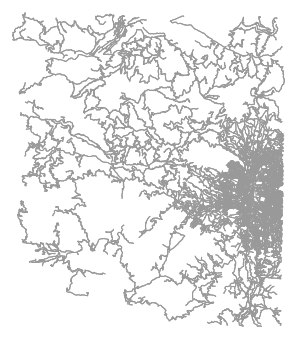

(<Figure size 364.878x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1628e7fe6d0>)

In [17]:
#new versions of osmnx use this line as clean_intersections has been deprecated
#intersectionsTraining = ox.consolidate_intersections(Gtraining_projected, rebuild_graph=False, tolerance=15, dead_ends=False)
intersectionsTraining = ox.clean_intersections(Gtraining_projected, tolerance=15, dead_ends=False)

pointsTraining = np.array([point.xy for point in intersectionsTraining])
ox.plot_graph(Gtraining_projected,node_alpha=0)

In [52]:
#get road intersections
pointGeometriesTraining = []
for point in pointsTraining:
    pointGeometriesTraining.append(Point(point))

nodeDFTraining = gpd.GeoDataFrame({'geometry':pointGeometriesTraining})
nodeSITraining = nodeDFTraining.sindex

In [53]:
#get roads
geometriesTraining = []
for u, v, data in Gtraining_projected.edges(keys=False, data=True):
    if 'geometry' in data:
        geometriesTraining.append(data['geometry'])

In [54]:
#return length of line in grid cell (clippingPoly)
def returnClippedLength(spatialIndex, DF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = DF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return (preciseClip.length).sum()

In [55]:
#return number of road intersections in grid cell
def returnClippedPoints(spatialIndex, DF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = DF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return len(preciseClip.index)

In [56]:
#return area of building footprints in cell
def returnClippedArea(spatialIndex, buildingDF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = buildingDF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return (preciseClip.area).sum()

In [57]:
#process road  lengths and intersection count in each cell
roadDFTraining = gpd.GeoDataFrame({'geometry':geometriesTraining})
roadSITraining = roadDFTraining.sindex

trainingLengths = []
trainingNodes = []

for i,row in enumerate(trainingDFProjected.geometry):
    trainingLengths.append(returnClippedLength(roadSITraining, roadDFTraining , row))
    trainingNodes.append(returnClippedPoints(nodeSITraining, nodeDFTraining, row))
print("done training roads")

done training roads


In [58]:
trainingForestJSON = eeForest(trainingFeatures)
print("done training forest")

done training forest


In [59]:
trainingTextureJSON = eeTexture(trainingFeatures, trainingJSON)
print("done training texture")

done training texture


In [60]:
trainingSlopeJSON = eeSlope(trainingFeatures)
print("done training slope")

done training slope


In [61]:
trainingVIIRS2019JSON = eeVIIRSNTL(trainingFeatures)
print("done training VIIRS NTL")

done training VIIRS NTL


In [62]:
trainingIndicesJSON = eeIndices(trainingFeatures, trainingJSON)
print("done training indices")

done training indices


In [63]:
trainingFootprints = ox.footprints_from_polygon(trainingJSON.bbox)
avg_longitude = (trainingBounds[0] + trainingBounds[2])/2
utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
print("projecting")
# project the GeoDataFrame to the UTM CRS
trainingFootprintsProjected = trainingFootprints.to_crs(utm_crs)

projecting


In [64]:
print("generating spatial index for building footprints")
trainingFootprintsSindex = trainingFootprintsProjected.sindex

generating spatial index for building footprints


In [65]:
#calculate building areas in each cell
trainingAreas = []
for i,row in enumerate(trainingDFProjected.geometry):
    trainingAreas.append(returnClippedArea(trainingFootprintsSindex, trainingFootprintsProjected, row))

In [66]:
#helper function to get values from objects returned from earth engine
def returnFeatureVals(featureString, variable):
    return [x['properties'][featureString] for x in variable['features']]

In [68]:
trainingFeatureDict = {
    'ndbi':returnFeatureVals('ndbi', trainingIndicesJSON),
    'ndvi':returnFeatureVals('ndvi', trainingIndicesJSON),
    'savi':returnFeatureVals('savi', trainingIndicesJSON),
    'ui':returnFeatureVals('ui', trainingIndicesJSON),
    'viirs':returnFeatureVals('viirs_2019_max', trainingVIIRS2019JSON),
    'slope':returnFeatureVals('mean', trainingSlopeJSON),
    'texture':returnFeatureVals('mean', trainingTextureJSON),
    'forest':returnFeatureVals('sum', trainingForestJSON),
    'popFB':trainingPopToAddFB,
    'popWP':trainingPopToAddWP,
    'popWSF':trainingPopToAddWSF,
    'roads':trainingLengths,
    'nodes':trainingNodes,
    'area':trainingAreas
}

trainingDF = pd.DataFrame.from_dict(trainingFeatureDict)
trainingGeoDF = gpd.GeoDataFrame(trainingDF,crs = 4326, geometry=trainingJSON.polygons)
trainingGeoDF = trainingGeoDF.fillna(0)

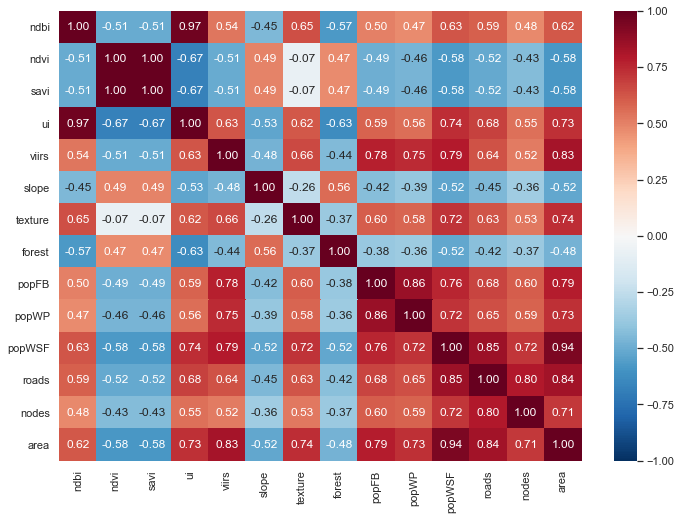

In [69]:
#plot correlation matrix
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(trainingGeoDF.corr(), annot=True, fmt=".2f",cmap='RdBu_r', center=0, vmin=-1, vmax=1)

In [70]:
trainingFeatureDF = trainingGeoDF[['ndbi','ndvi','savi','ui','viirs','slope','texture','forest','popFB','popWP','roads','nodes','popWSF']]
trainingTargetDF = trainingGeoDF['area']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(trainingFeatureDF, trainingTargetDF, test_size=0.3, random_state=42)

0.9553874028039785
1169.4880676219077


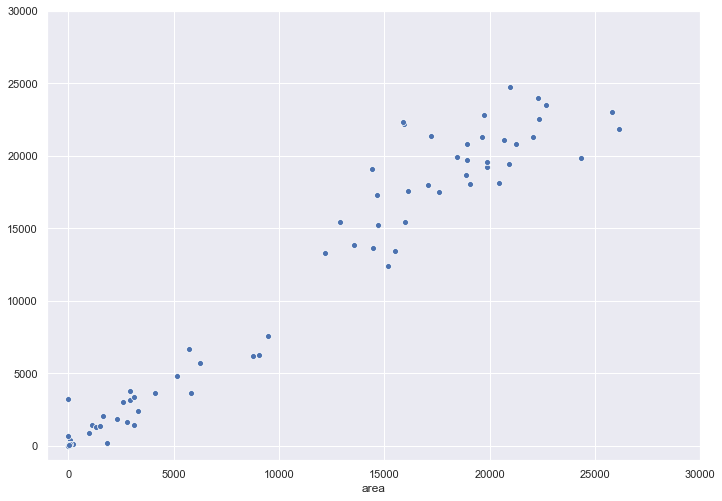

In [72]:
#fit with default settings for reference (70/30 training/test split, no cross validation)
RandomForest = RandomForestRegressor()
RandomForest.fit(X_train, y_train)
y_pred = RandomForest.predict(X_test)
print(r2_score(y_test,y_pred))
ax1 = sns.scatterplot(x=y_test,y=y_pred)
ax1.set(ylim=(-1000, 30000))
ax1.set(xlim=(-1000, 30000))
print(mean_absolute_error(y_test,y_pred))

In [73]:
#fit with optimized settings (takes a few minutes)

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}
0.9550313537325766
1200.560565683452


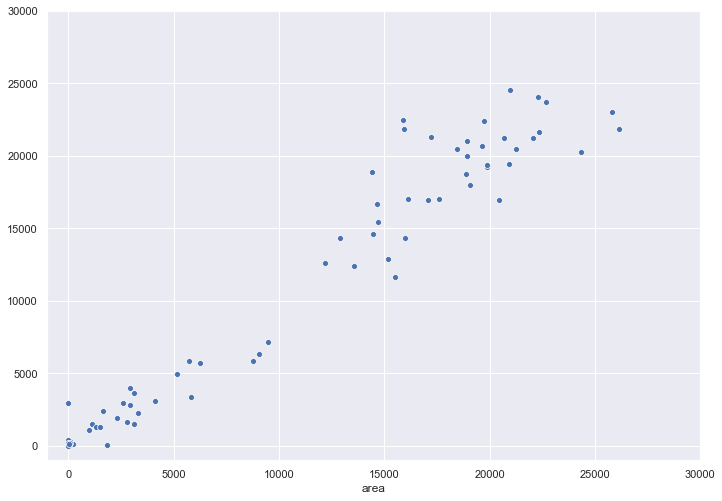

In [74]:
print(rf_random.best_params_)
best_random = rf_random.best_estimator_
y_pred = best_random.predict(X_test)
print(r2_score(y_test,y_pred))
ax = sns.scatterplot(x=y_test,y=y_pred)
ax.set(ylim=(-1000, 30000))
ax.set(xlim=(-1000, 30000))
print(mean_absolute_error(y_test,y_pred))

In [75]:
import joblib
#define location to save model
filename = r'path_to_output_model\trained.sav'
joblib.dump(best_random, filename)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_output_model\\trained.sav'